In [31]:
import pandas as pd
import numpy as np

from IPython.display import display, clear_output  # Import clear_output and display
import PIL.Image
import cv2
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

In [2]:
class EmotionRec(nn.Module):
    def __init__(self):
        super(EmotionRec, self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*6*6, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024,4)
        )

    def forward(self,x):
        x=self.features(x)
        x=self.classifier(x)
        return x

In [3]:
class EmotionDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0  
        image = image.reshape(48, 48, 1) 
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs, 1)
            train_correct += (predictions == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        
        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predictions = torch.max(outputs, 1)
                val_correct += (predictions == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model

In [8]:
def main():
    df=pd.read_csv("fer2013.csv")

    emotions_to_keep = {0: 'Angry', 3: 'Happy', 4: 'Sad', 6: 'Calm'}
    df = df[df['emotion'].isin(emotions_to_keep.keys())]

    new_label_map = {old_label: new_label for new_label, old_label in enumerate(emotions_to_keep.keys())}

    labels = df['emotion'].map(new_label_map).values
    pixels = df['pixels'].apply(lambda x: np.array(x.split()).astype(int)).values

    X_train, X_val, y_train, y_val = train_test_split(pixels, labels, test_size=0.2, random_state=42)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    train_dataset = EmotionDataset(X_train, y_train, transform=transform)
    val_dataset = EmotionDataset(X_val, y_val, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = EmotionRec()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    torch.save(trained_model.state_dict(), 'emotion_recognition_model.pth')

In [9]:
if __name__ == "__main__":
    main()

Epoch 1/10:
Train Loss: 1.2771, Train Acc: 0.4064
Val Loss: 1.0895, Val Acc: 0.5288
Epoch 2/10:
Train Loss: 1.0394, Train Acc: 0.5451
Val Loss: 0.9418, Val Acc: 0.5814
Epoch 3/10:
Train Loss: 0.9422, Train Acc: 0.5970
Val Loss: 0.9216, Val Acc: 0.6117
Epoch 4/10:
Train Loss: 0.8845, Train Acc: 0.6289
Val Loss: 0.8550, Val Acc: 0.6358
Epoch 5/10:
Train Loss: 0.8388, Train Acc: 0.6501
Val Loss: 0.8137, Val Acc: 0.6623
Epoch 6/10:
Train Loss: 0.7949, Train Acc: 0.6708
Val Loss: 0.8059, Val Acc: 0.6638
Epoch 7/10:
Train Loss: 0.7635, Train Acc: 0.6837
Val Loss: 0.7897, Val Acc: 0.6773
Epoch 8/10:
Train Loss: 0.7298, Train Acc: 0.7031
Val Loss: 0.7817, Val Acc: 0.6810
Epoch 9/10:
Train Loss: 0.7076, Train Acc: 0.7117
Val Loss: 0.7927, Val Acc: 0.6827
Epoch 10/10:
Train Loss: 0.6815, Train Acc: 0.7233
Val Loss: 0.7903, Val Acc: 0.6760


In [11]:
model = EmotionRec()
model.load_state_dict(torch.load('emotion_recognition_model.pth'))
model.eval()

EmotionRec(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=4, bias=True)
  )
)

In [14]:
emotion_dict = {0: "Angry", 1: "Happy", 2: "Sad", 3: "Calm"}

In [15]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [21]:
def emotion_recog(frame):
    # prevents openCL usage and unnecessary logging messages
    cv2.ocl.setUseOpenCL(False)

    # Detect faces using OpenCV
    facecasc = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y - 50), (x + w, y + h + 10), (255, 0, 255), 3)
        roi_gray = gray[y:y + h, x:x + w]

        # Preprocess the face image
        cropped_img = cv2.resize(roi_gray, (48, 48))
        cropped_img = np.expand_dims(cropped_img, axis=2)
        cropped_img = transform(cropped_img).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            prediction = model(cropped_img)
            maxindex = int(torch.argmax(prediction))

        # Put emotion label on the frame
        cv2.putText(frame, emotion_dict[maxindex], (x + 20, y - 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return frame

In [22]:
def display_frame_in_notebook(frame):
    """Display a single frame in a Jupyter Notebook."""
    clear_output(wait=True)  # Clear the previous frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert color for notebook display
    pil_img = PIL.Image.fromarray(frame)  # Convert to PIL image
    display(pil_img)  # Display the image


In [29]:
def capture_and_identify_emotions():
    cap = cv2.VideoCapture(0)  # Capture video from the camera

    if not cap.isOpened():
        print("Error: Could not open video stream.")
        return

    try:
        while True:
            # Read frame from the video capture
            ret, frame = cap.read()

            if not ret:
                print("Error: Failed to capture image.")
                break

            # Call emotion_recog to detect emotions in the current frame
            frame_with_emotions = emotion_recog(frame)

            # Display the frame in the Jupyter Notebook
            display_frame_in_notebook(frame_with_emotions)

            # Add a short sleep to reduce CPU usage (optional)
            time.sleep(0.1)

    except KeyboardInterrupt:
        print("Stopped by user.")

    finally:
        # Release the video capture object
        cap.release()



In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

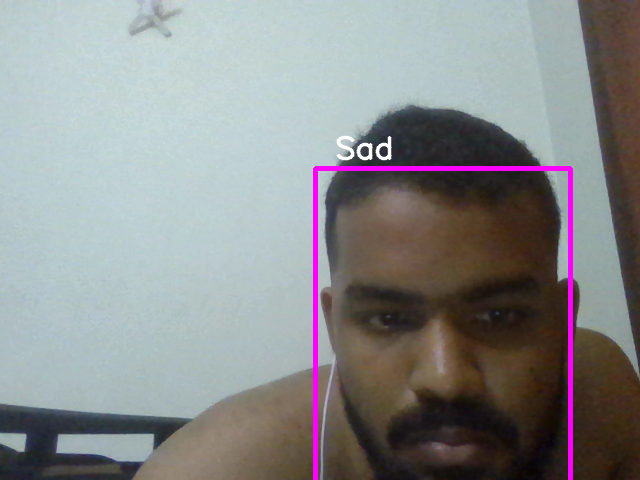

Stopped by user.


In [32]:
capture_and_identify_emotions()

In [37]:
import pandas as pd

# Load your dataset
song_features_df = pd.read_csv("genres_v2.csv")

# Display the first few rows to ensure it loaded correctly
print(song_features_df.head())

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence  ...                      id  \
0          0.013400    0.0556   0.3890  ...  2Vc6NJ9PW9gD9q343XFRKx   
1          0.000000    0.1180   0.1240  ...  7pgJBLVz5VmnL7uGHmRj6p   
2          0.000004    0.3720   0.0391  ...  0vSWgAlfpye0WCGeNmuNhy   
3          0.000000    0.1140   0.1750  ...  0VSXnJqQkwuH2ei1nOQ1nu   
4          0.000000    0.1660   0.5910  ...  4jCeguq9rMTlbMmPHuO7S3   

                                    uri  \
0  spotify:track:2Vc6NJ9PW9gD9q343XFRKx   
1  spotify:track:7pgJBLVz5VmnL7uGHmR

C:\Users\frank\AppData\Local\Temp\ipykernel_52012\3952919283.py:4: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  song_features_df = pd.read_csv("genres_v2.csv")


In [38]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Select relevant features for PCA (you might adjust this based on your analysis)
X = song_features_df[['valence', 'energy', 'danceability', 'loudness', 'acousticness']]

# Apply PCA to reduce to 4 principal components
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

# Perform K-Means clustering into 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add clusters and mood mapping to the dataframe
song_features_df['cluster'] = clusters

# Map clusters to moods
cluster_to_mood = {
    0: 'angry',   # Low valence, high energy
    1: 'sad',     # Very low valence, low energy
    2: 'calm',    # Low valence, low energy
    3: 'happy'    # High valence, high energy
}
song_features_df['mood'] = song_features_df['cluster'].map(cluster_to_mood)

In [44]:
import random

def get_random_songs(mood, song_db, n=5):
    # Filter songs based on mood
    mood_songs = song_db[song_db['mood'] == mood]
    # Return n random songs, including only song_name and uri, but keep the original index
    return mood_songs[['song_name', 'uri']].sample(n).reset_index()

# Example: Get 5 random 'happy' songs
random_songs = get_random_songs('happy', song_features_df)
print(random_songs)

# Example usage: User selects a song from the 5 random songs
selected_song_index = random_songs.iloc[0]['index']  # Get the index of the selected song
selected_song = song_features_df.loc[selected_song_index]  # Get the full row from the original dataframe

# Run content-based recommendation
recommended_songs = content_based_recommendation(selected_song, song_features_df[song_features_df['mood'] == 'happy'])
print(recommended_songs[['song_name', 'uri', 'similarity']])

   index              song_name                                   uri
0   1752                Comet 2  spotify:track:5okAyGMg6mP4mIIhc1dsHB
1  24896                    NaN  spotify:track:06ZaIdip29PHwZ1mae6Jbs
2  26130                    NaN  spotify:track:0JcNMoICXpY6gLZK12MjjE
3  21091  Welcome To the Ghetto  spotify:track:7KqCsGOyUOiwA59B3wgmnr
4   3010           Day Dreamers  spotify:track:5AgeK2ceDRwKk8cUcUFHqY
              song_name                                   uri  similarity
1752            Comet 2  spotify:track:5okAyGMg6mP4mIIhc1dsHB    1.000000
2978  Let Me Let You Go  spotify:track:1NPAjVzH75lWwEJOEEKO2x    0.999996
3014            Go Away  spotify:track:0buI3bJzsbFyLLQZnqb4Fr    0.999986


C:\Users\frank\AppData\Local\Temp\ipykernel_52012\2042347526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mood_songs['similarity'] = similarities[0]


In [43]:
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendation(selected_song, mood_songs):
    # Get features for the selected song and reshape to 2D array
    selected_song_features = selected_song[['valence', 'energy', 'danceability', 'loudness', 'acousticness']].values.reshape(1, -1)
    mood_song_features = mood_songs[['valence', 'energy', 'danceability', 'loudness', 'acousticness']].values
    
    # Calculate cosine similarity
    similarities = cosine_similarity(selected_song_features, mood_song_features)
    
    # Add similarities to mood songs DataFrame
    mood_songs['similarity'] = similarities[0]
    
    # Return top N recommended songs
    return mood_songs.sort_values('similarity', ascending=False).head(3)

# Example usage: User selects a song from the 5 random songs
selected_song_index = random_songs.iloc[0]['index']  # Get the index of the selected song
selected_song = song_features_df.loc[selected_song_index]  # Get the full row from the original dataframe

# Run content-based recommendation
recommended_songs = content_based_recommendation(selected_song, song_features_df[song_features_df['mood'] == 'happy'])
print(recommended_songs[['song_name', 'uri', 'similarity']])

           song_name                                   uri  similarity
17134  Death & Taxes  spotify:track:7HnkUNPrhRurdGEm9nRYFH    1.000000
13387          Sober  spotify:track:0STK94RxUulYqWzwFlyAb5    0.999985
19704            You  spotify:track:3LBCD2JEscvWYsKxi7ZZNJ    0.999984


C:\Users\frank\AppData\Local\Temp\ipykernel_52012\2042347526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mood_songs['similarity'] = similarities[0]


In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Set your Spotify API credentials
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id="420b73e02a0d4ec6aa5fec7ac8ae6b64",
                                               client_secret="3522e9079ba9479da0b22ce748c61d22",
                                               redirect_uri="http://127.0.0.1:8888/callback",
                                               scope="user-read-playback-state user-modify-playback-state user-read-currently-playing"))

# Function to play song using Spotify API
def play_song_on_spotify(song_name):
    result = sp.search(q=song_name, type='track', limit=1)
    
    if result['tracks']['items']:
        track_uri = result['tracks']['items'][0]['uri']
        sp.start_playback(uris=[track_uri])
        print(f"Now playing: {song_name}")
    else:
        print(f"Song '{song_name}' not found on Spotify.")

# Play the top recommended song
top_song = recommended_songs.iloc[0]['song_name']
play_song_on_spotify(top_song)

NameError: name 'recommended_songs' is not defined